In [2]:
import os
import cv2
from shutil import copyfile
import matplotlib.pyplot as plt
import csv
import random
import cv2
import numpy as np
from skimage import data
from skimage import exposure
from skimage.transform import match_histograms

In [5]:
def hist_match(source, template):
    """
    Adjust the pixel values of a grayscale image such that its histogram
    matches that of a target image

    Arguments:
    -----------
        source: np.ndarray
            Image to transform; the histogram is computed over the flattened
            array
        template: np.ndarray
            Template image; can have different dimensions to source
    Returns:
    -----------
        matched: np.ndarray
            The transformed output image
    """

    oldshape = source.shape
    source = source.ravel()
    template = template.ravel()

    # get the set of unique pixel values and their corresponding indices and
    # counts
    s_values, bin_idx, s_counts = np.unique(source, return_inverse=True,
                                            return_counts=True)
    t_values, t_counts = np.unique(template, return_counts=True)

    # take the cumsum of the counts and normalize by the number of pixels to
    # get the empirical cumulative distribution functions for the source and
    # template images (maps pixel value --> quantile)
    s_quantiles = np.cumsum(s_counts).astype(np.float64)
    s_quantiles /= s_quantiles[-1]
    t_quantiles = np.cumsum(t_counts).astype(np.float64)
    t_quantiles /= t_quantiles[-1]

    # interpolate linearly to find the pixel values in the template image
    # that correspond most closely to the quantiles in the source image
    interp_t_values = np.interp(s_quantiles, t_quantiles, t_values)

    return interp_t_values[bin_idx].reshape(oldshape)

In [6]:
image_root = "/media/arg_ws3/5E703E3A703E18EB/data/mm_FCN/unity/image/"
mask_root = "/media/arg_ws3/5E703E3A703E18EB/data/mm_FCN/unity/mask/"
box_root = "/media/arg_ws3/5E703E3A703E18EB/data/mm_FCN/unity/box/"
realbox_root = "/media/arg_ws3/5E703E3A703E18EB/data/MM_BOX/train/B/"
realbox_list = os.listdir(realbox_root)
box_list = os.listdir(box_root)

In [126]:
def s_p(image, prob):
    output = np.zeros(image.shape,np.uint8)
    thres = 1 - prob 
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            rdn = random.random()
            if rdn < prob:
                output[i][j] = 0
            elif rdn > thres:
                output[i][j] = 255
            else:
                output[i][j] = image[i][j]
    return output

5
0.0006


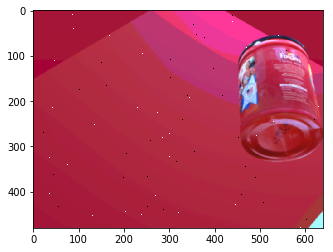

In [129]:
box = box_list[random.randint(0,len(box_list)-1)]
mask_name = box.split('_original.png')[0] + '_seg.png'
fake_img = cv2.imread(os.path.join(box_root, box))
real_img = cv2.imread(os.path.join(realbox_root, realbox_list[random.randint(0,len(realbox_list)-1)]))
matched = match_histograms(fake_img, real_img, multichannel=True)
matched = hist_match(fake_img, real_img).astype(np.uint8)
image = cv2.imread(os.path.join(image_root, box))
mask_img = cv2.imread(os.path.join(mask_root, mask_name), 0)
mask_img[mask_img != 0 ] = 255
mask_img = mask_img - 255
mask_img[mask_img != 0 ] = 255
mask = cv2.cvtColor(mask_img, cv2.COLOR_GRAY2RGB)
matched = cv2.bitwise_and(matched, mask, mask=mask_img)
mask_img[mask_img < 255] = 1
mask_img[mask_img == 255] = 0
mask_img[mask_img == 1] = 255
mask = cv2.cvtColor(mask_img, cv2.COLOR_GRAY2RGB)
image = cv2.bitwise_and(image, mask, mask=mask_img)
result = cv2.add(matched, image)
rand_blur = int(random.randint(0, 7)*2) + 1
print(rand_blur)
result = cv2.GaussianBlur(result, (rand_blur, rand_blur), 0)
s_p_noise = random.randint(0, 40)/10000
print(s_p_noise)
result = s_p(result, s_p_noise)
#cv2.imwrite(os.path.join(root, box), result)
#cv2.imwrite(os.path.join(root, box), result)
plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))

In [128]:
root = "/media/arg_ws3/5E703E3A703E18EB/data/mm_FCN/histogram/image/"
image_root = "/media/arg_ws3/5E703E3A703E18EB/data/mm_FCN/unity/image/"
mask_root = "/media/arg_ws3/5E703E3A703E18EB/data/mm_FCN/unity/mask/"
box_root = "/media/arg_ws3/5E703E3A703E18EB/data/mm_FCN/unity/box/"
realbox_root = "/media/arg_ws3/5E703E3A703E18EB/data/mm_unity/real_boxes/"
realbox_list = os.listdir(realbox_root)
box_list = os.listdir(box_root)

In [129]:
for box in box_list:
    mask_name = box.split('_original.png')[0] + '_seg.png'
    fake_img = cv2.imread(os.path.join(box_root, box))
    real_img = cv2.imread(os.path.join(realbox_root, realbox_list[random.randint(0,len(realbox_list)-1)]))
    matched = match_histograms(fake_img, real_img, multichannel=True)
    image = cv2.imread(os.path.join(image_root, box))
    mask_img = cv2.imread(os.path.join(mask_root, mask_name), 0)
    mask_img[mask_img > 0] = 255
    mask = cv2.cvtColor(mask_img, cv2.COLOR_GRAY2RGB)
    matched = cv2.bitwise_and(matched, mask, mask=mask_img)
    mask_img[mask_img < 255] = 1
    mask_img[mask_img == 255] = 0
    mask_img[mask_img == 1] = 255
    mask = cv2.cvtColor(mask_img, cv2.COLOR_GRAY2RGB)
    image = cv2.bitwise_and(image, mask, mask=mask_img)
    result = cv2.add(matched, image)
    cv2.imwrite(os.path.join(root, box), result)